In [5]:
import torch

# Create example tensors with batch size 2 and state dimension 4
grad_b = torch.tensor([[2.0, 3.0, 1.0, 4.0], [5.0, 1.0, 2.0, 0.0]])
x_dot = torch.tensor([[1.0, 2.0, 3.0, 4.0], [0.0, 5.0, 6.0, 7.0]])

# Approach 1: Using torch.sum
b_dot_sum = torch.sum(grad_b * x_dot, axis=1)

# Approach 2: Using torch.einsum
b_dot_einsum = torch.einsum('bo,bo->b', grad_b, x_dot)

# Verify that both approaches give the same result
print(torch.allclose(b_dot_sum, b_dot_einsum))  # Should print: True

# Print the shapes of the results to confirm they are (2,)
print(b_dot_sum.shape)  # torch.Size([2])
print(b_dot_einsum.shape)  # torch.Size([2])

# Print the results
print("Dot product using torch.sum:", b_dot_sum)
print("Dot product using torch.einsum:", b_dot_einsum)




True
torch.Size([2])
torch.Size([2])
Dot product using torch.sum: tensor([27., 17.])
Dot product using torch.einsum: tensor([27., 17.])


In [7]:
import torch

# Define dimensions for the example
batch_size = 2
state_dim = 3
num_action = 4

# Create a tensor with the shape [batch_size, state_dim * num_action]
g = torch.randn(batch_size, state_dim * num_action)

# Print the original shape of g
print("Original g shape:", g.shape)

# Reshape g using view to [batch_size, state_dim, num_action]
g_reshaped = g.view(batch_size, state_dim, num_action)

# Print the reshaped tensor
print("Reshaped g shape:", g_reshaped.shape)

# Now, let's simulate the 'action' tensor, which is of shape [batch_size, num_action]
action = torch.randn(batch_size, num_action)

# Using einsum to perform the matrix multiplication (gu = g * action)
gu = torch.einsum('bsa,ba->bs', g_reshaped, action)

# Print the result of einsum
print("Result of einsum (gu):", gu)


Original g shape: torch.Size([2, 12])
Reshaped g shape: torch.Size([2, 3, 4])
Result of einsum (gu): tensor([[-2.2397, -2.4037,  2.1775],
        [-0.4013,  0.4802, -0.3619]])


OfflineHopperVelocityGymnasium-v1(1322478, 11)

OfflineAntVelocityGymnasium-v1 Observations shape: (2092264, 27)

OfflineSwimmerVelocityGymnasium-v1 Observations shape: (1686000, 8)

Model loaded successfully!
Loading dataset from /Users/i.k.tabbara/.dsrl/datasets/SafetyHopperVelocityGymnasium-v1-250-2240.hdf5


load datafile: 100%|██████████| 7/7 [00:00<00:00,  8.45it/s]


original size = 1322478, cost limit = 10, filtered size = 1322478
tensor([[ 0.5278],
        [-0.6647],
        [ 0.7550],
        [ 0.8623],
        [ 0.8222],
        [-1.0000],
        [ 0.9734],
        [-0.9994],
        [-1.0000],
        [ 0.9315],
        [-0.7652],
        [-0.0693],
        [ 0.5716],
        [ 0.8921],
        [-1.0000],
        [ 0.6154],
        [ 0.8901],
        [ 0.2496],
        [ 0.9791],
        [ 0.9915]], grad_fn=<SliceBackward0>)
tensor([0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0.])


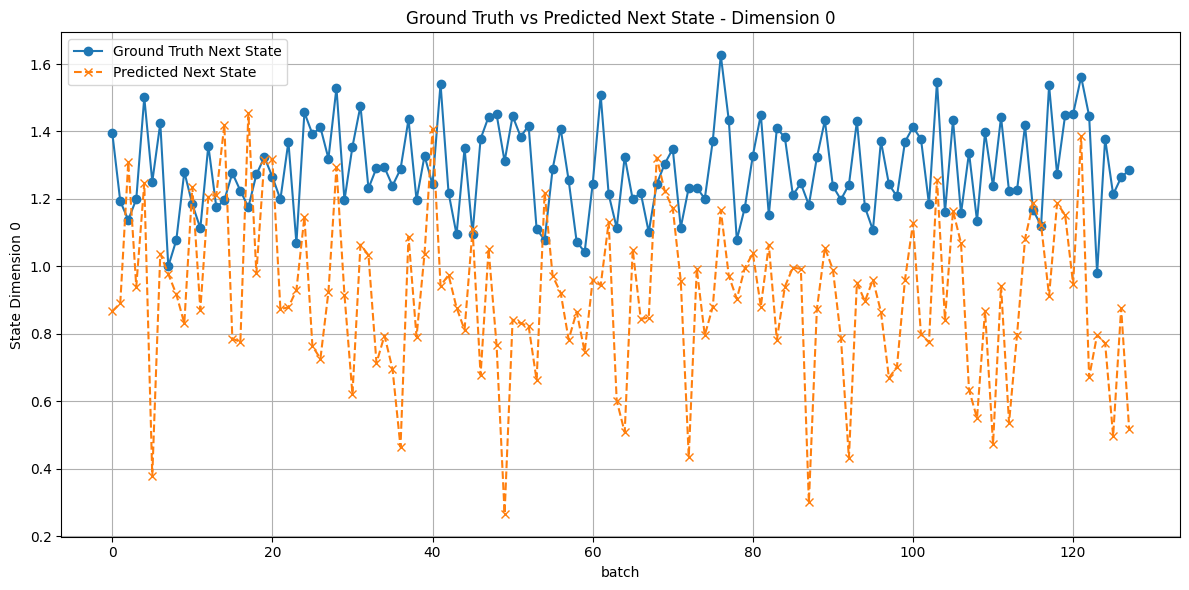

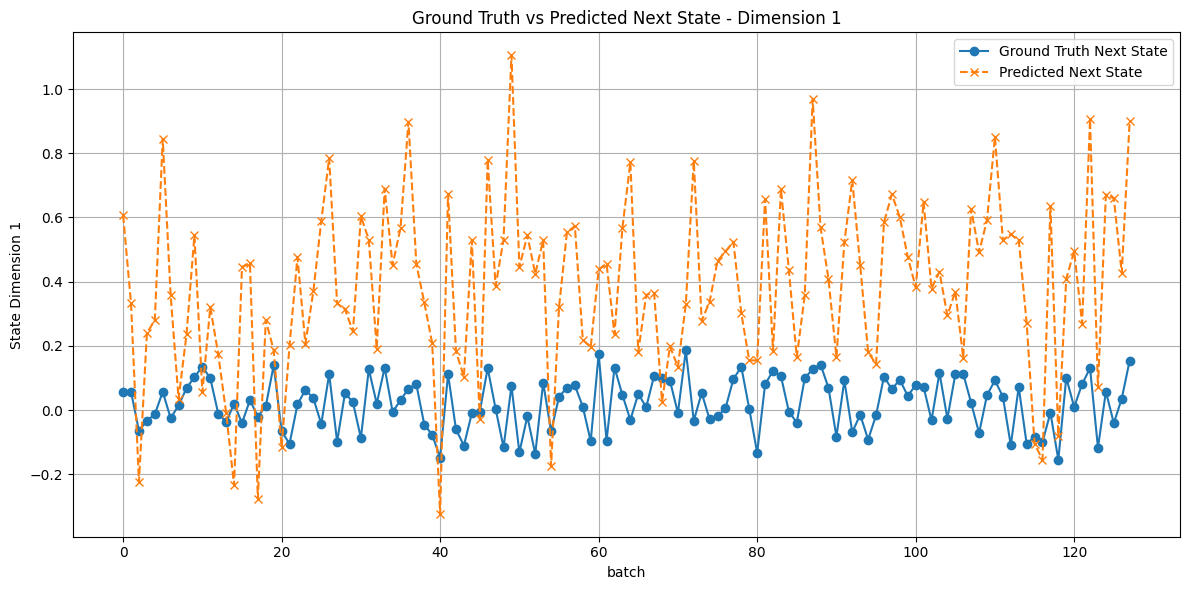

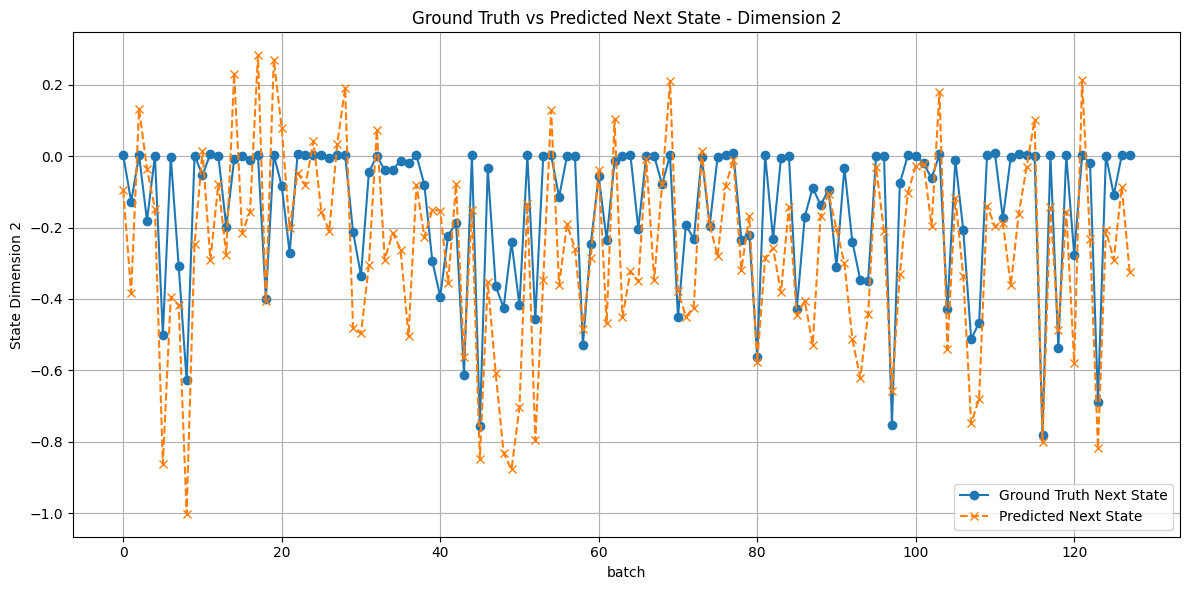

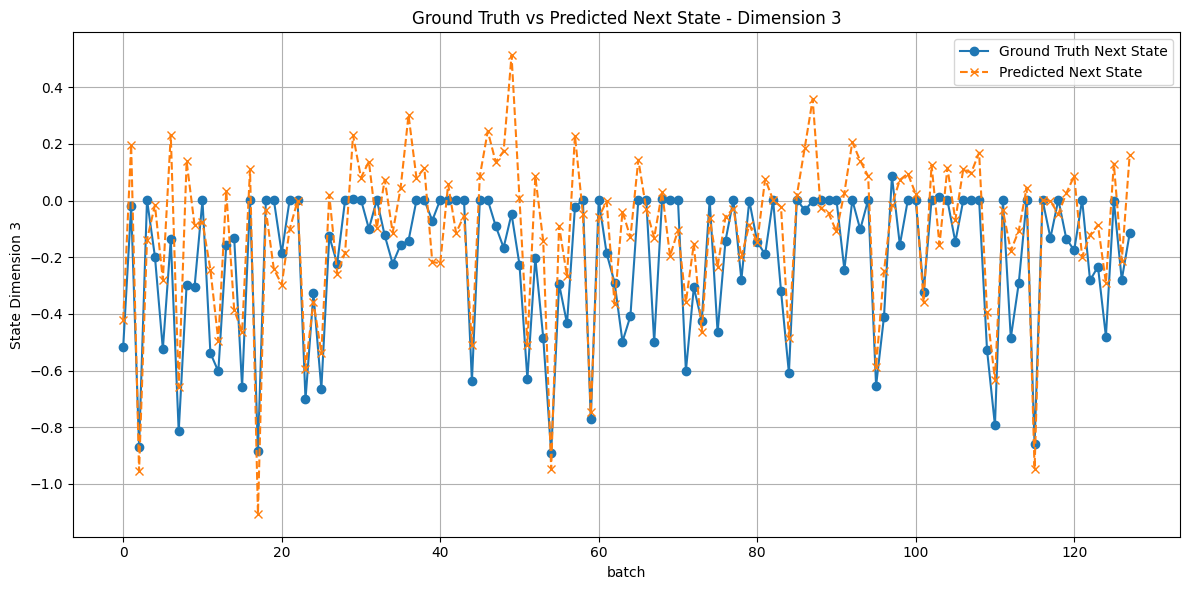

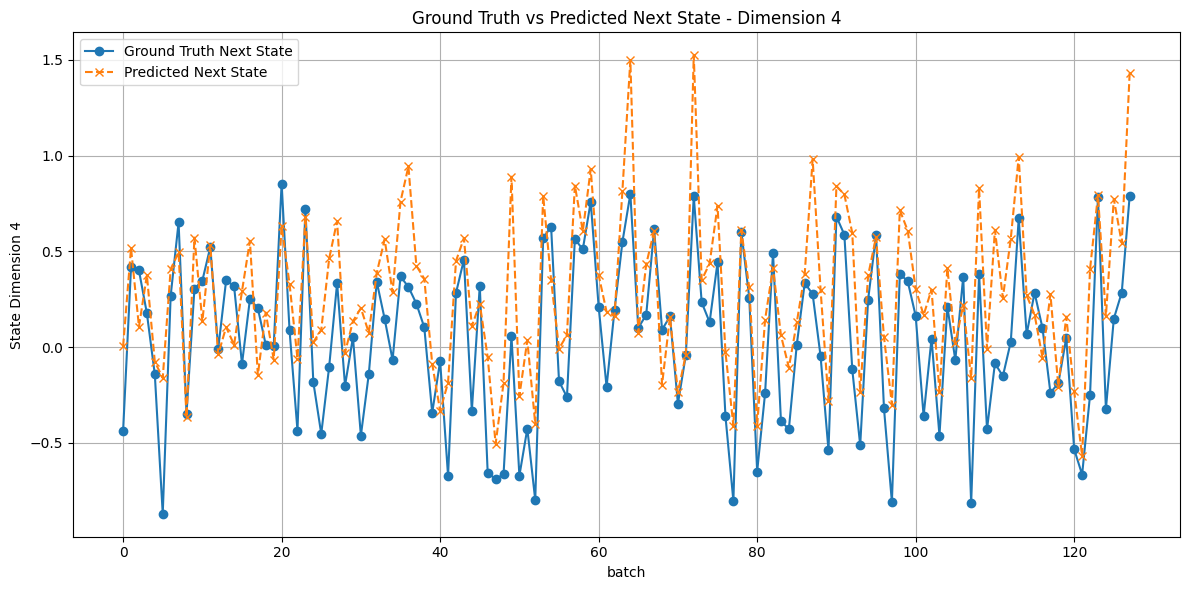

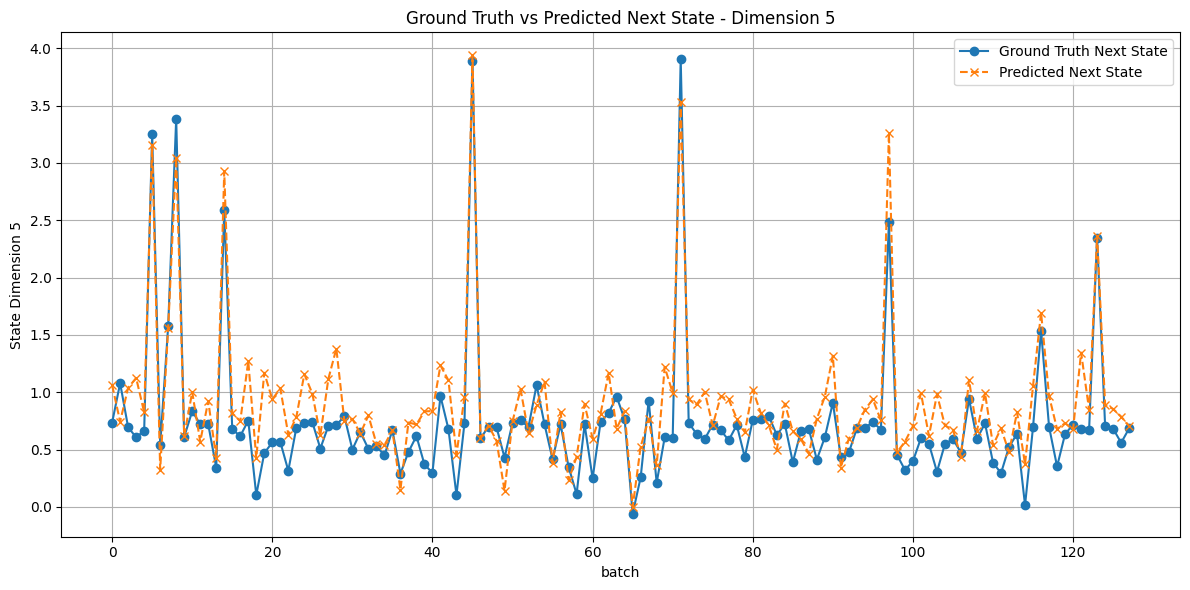

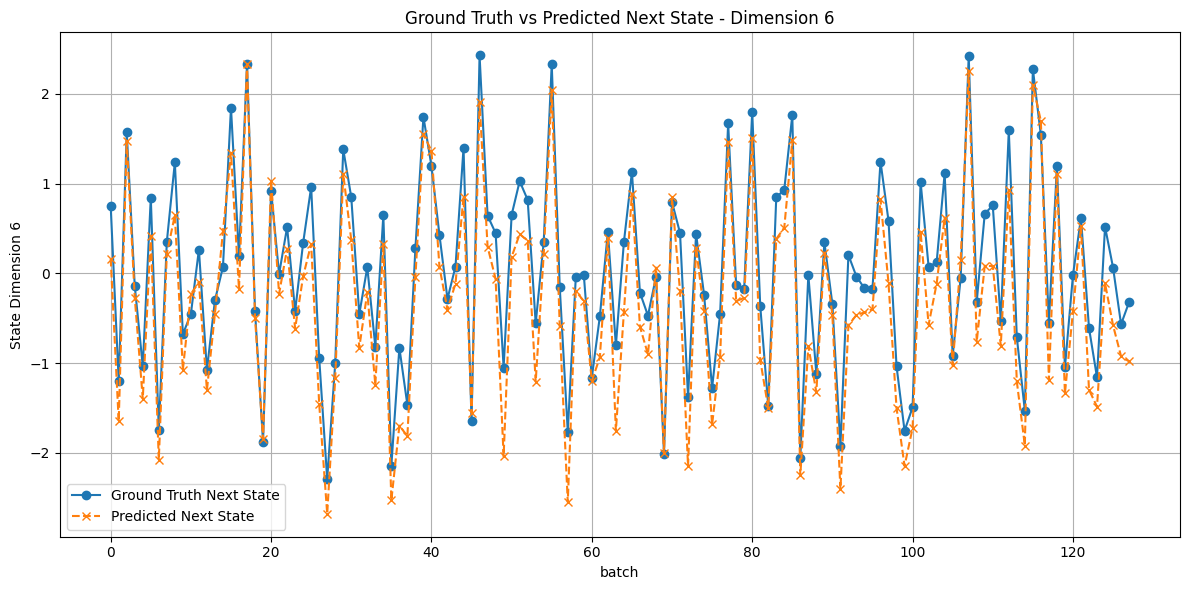

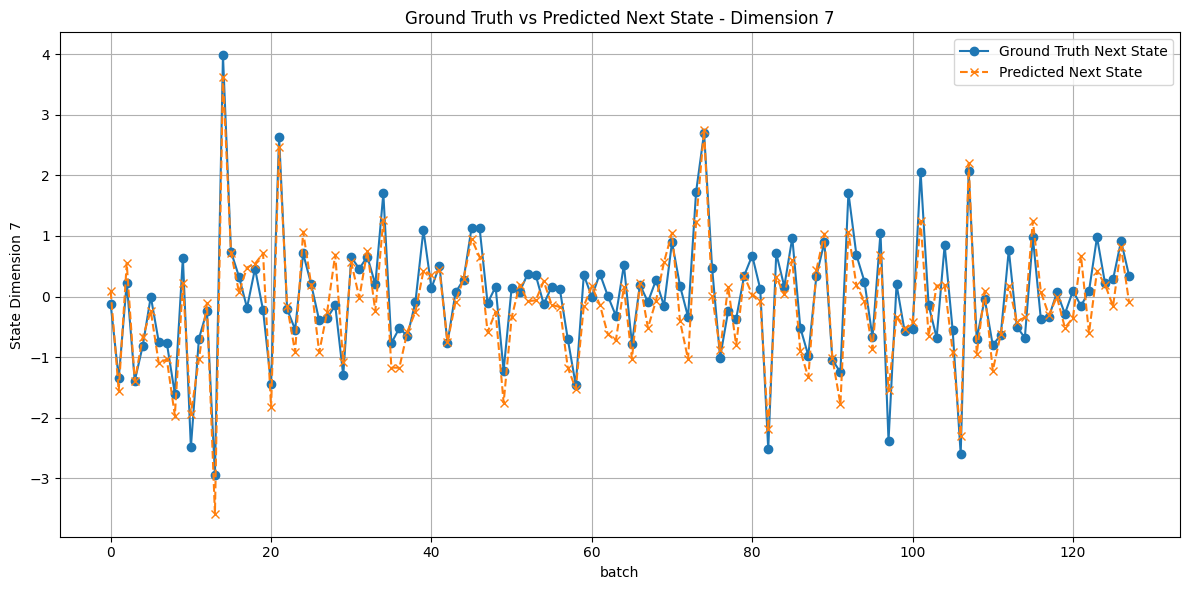

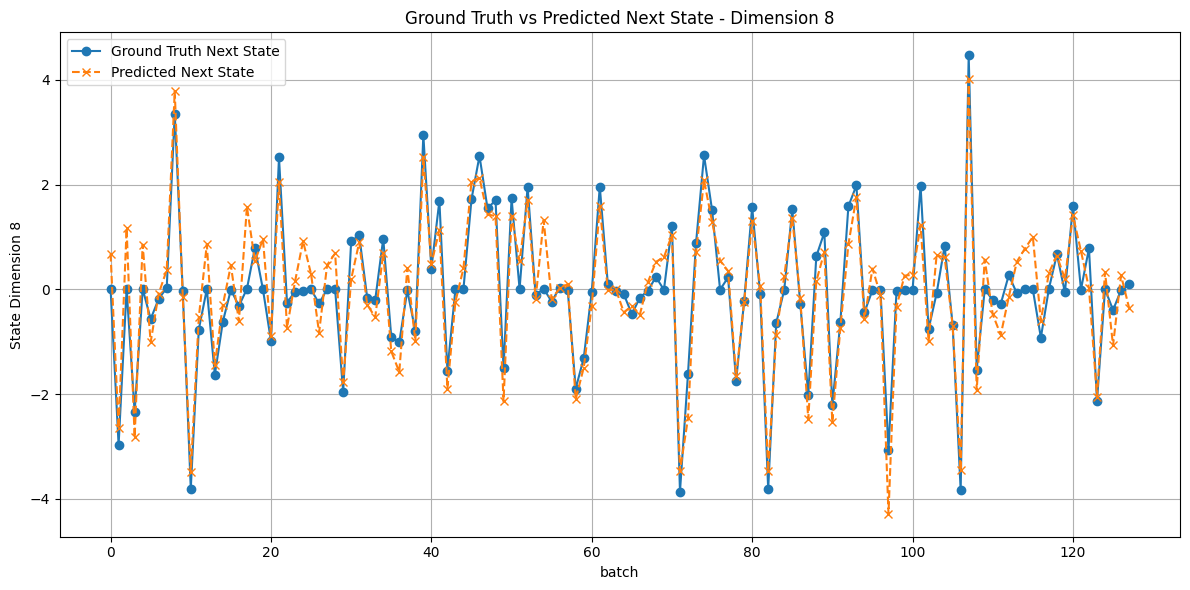

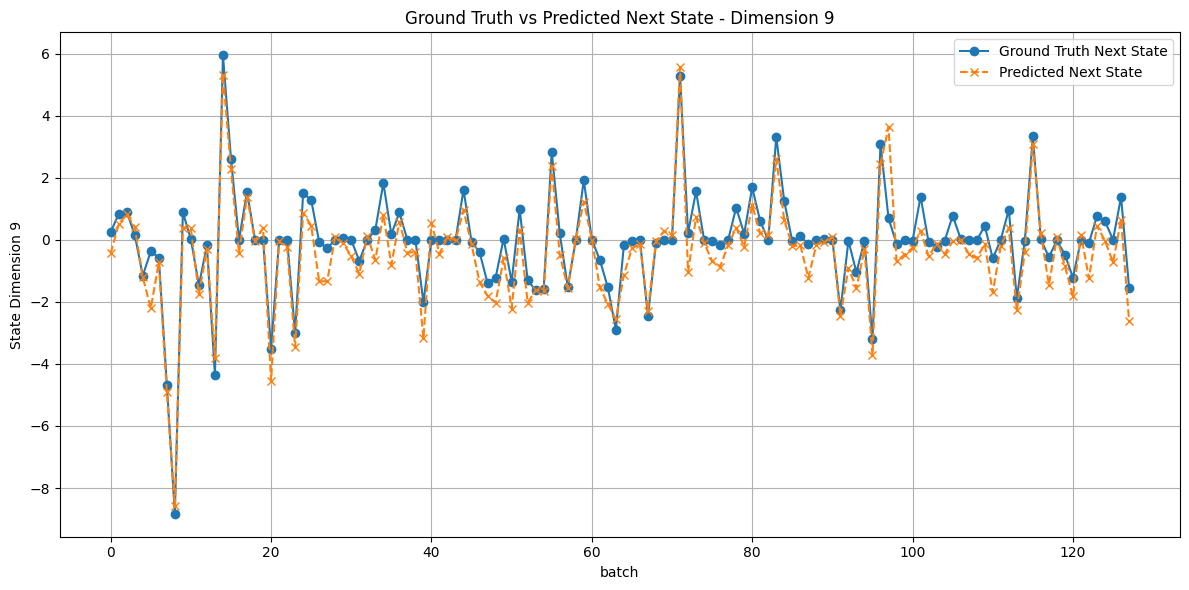

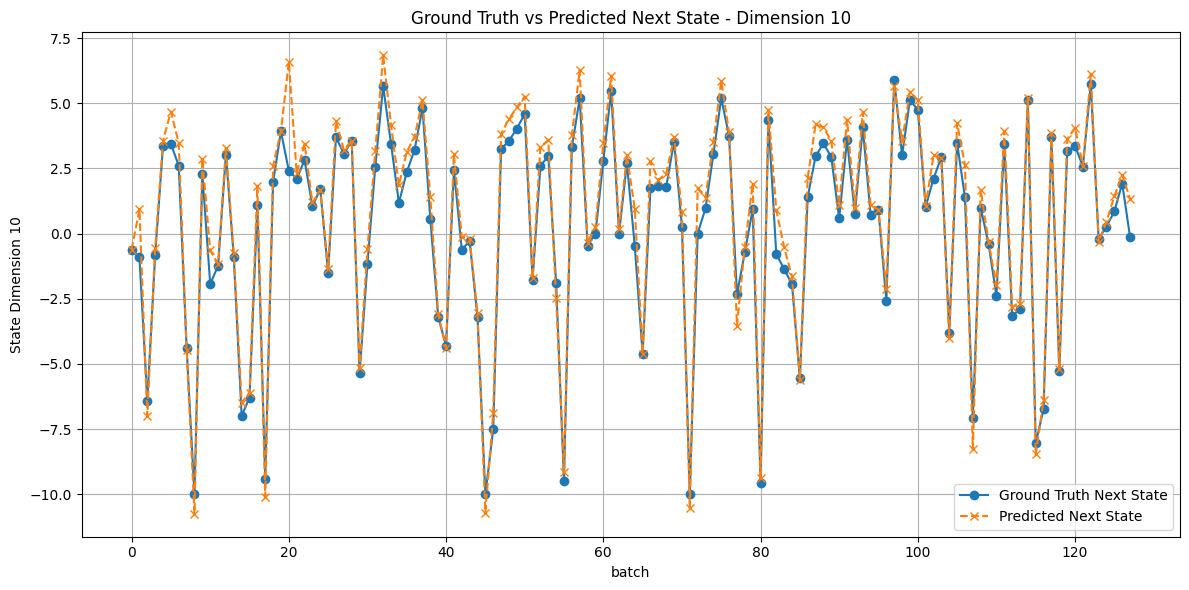


Mean Squared Error: 0.20027028024196625
Mean Absolute Error: 0.33962497115135193


In [8]:
import os
import sys
import uuid
import types
from dataclasses import asdict
from typing import Any
import json
import random

sys.path.append("/Users/i.k.tabbara/Documents/python directory/OSRL")

import bullet_safety_gym  # noqa
import dsrl
import safety_gymnasium as gym
import numpy as np
import pyrallis
import torch
import wandb
from dsrl.infos import DENSITY_CFG
from dsrl.offline_env import OfflineEnvWrapper, wrap_env  # noqa
from torch.utils.data import DataLoader
from tqdm.auto import trange
from examples.configs.bc_configs import BC_DEFAULT_CONFIG, BCTrainConfig

from osrl.algorithms import BC, BCTrainer
from osrl.common.dataset import process_bc_dataset
from osrl.common.exp_util import auto_name, seed_all

from network_ihab import AffineDynamics, CBF, CombinedCBFDynamics
from dataset_ihab import TransitionDataset
import torch.nn.functional as F
import torch
import json
import matplotlib.pyplot as plt
seed_all(0)
# Paths to your model and hyperparameter file

# model_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineCarGoal1Gymnasium-v0_843/combined_model.pth"
# hyperparams_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineCarGoal1Gymnasium-v0_843/hyperparameters.json"

# model_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineAntVelocityGymnasium-v1_971/combined_model.pth"
# hyperparams_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineAntVelocityGymnasium-v1_971/hyperparameters.json"

# model_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_217/combined_model.pth"
# hyperparams_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_217/hyperparameters.json"

model_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineHopperVelocityGymnasium-v1_624/combined_model_laststep.pth"
hyperparams_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineHopperVelocityGymnasium-v1_624/hyperparameters.json"

# Load hyperparameters
with open(hyperparams_path, 'r') as f:
    hyperparams = json.load(f)

# Initialize model with hyperparameters
combinedcbfdynamics = CombinedCBFDynamics(
    num_action=hyperparams['num_action'],
    state_dim=hyperparams['state_dim'],
    cbf_hidden_dim=hyperparams['cbf_hidden_dim'],
    dynamics_hidden_dim=hyperparams['dynamics_hidden_dim'],
    cbf_num_layers=hyperparams['cbf_num_layers'],
    dynamics_num_layers=hyperparams['dynamics_num_layers'],
    dt=hyperparams['dt']
)

# Load checkpoint
checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
combinedcbfdynamics.load_state_dict(checkpoint)

# Set model to evaluation mode
combinedcbfdynamics.eval()

print("Model loaded successfully!")

args = BCTrainConfig()
cfg, old_cfg = asdict(args), asdict(BCTrainConfig())
differing_values = {key: cfg[key] for key in cfg if cfg[key] != old_cfg[key]}
cfg = asdict(BC_DEFAULT_CONFIG[args.task]())
cfg.update(differing_values)
args = types.SimpleNamespace(**cfg)

args.seed = 7  # Changed seed
seed_all(args.seed)
if args.device == "cpu":
    torch.set_num_threads(args.threads)
import gymnasium as gym
args.task = hyperparams['task']
env = gym.make(args.task)
data = env.get_dataset()

##


env.set_target_cost(args.cost_limit)

process_bc_dataset(data, args.cost_limit, args.gamma, args.bc_mode)

# Create a dataset and dataloader
dataset = TransitionDataset(data)
dataloader = DataLoader(dataset, batch_size=128)

# env = wrap_env(
#         env=gym.make("OfflineSwimmerVelocityGymnasium-v1", render_mode="human"),## ADDED THIS changed this to "SafetyCarGoal1Gymnasium-v0" from OfflineCarGoal1Gymnasium-v0 as mentioned in yaml file
#                                          ##changed this from OfflinePointGoal1Gymnasium-v0 as in yaml file to SafetyPointGoal1Gymnasium-v0
#     )
# Get a batch of data
batch = next(iter(dataloader))
observations, next_observations, actions, _, costs, done = [b.to(torch.float32).to("cpu") for b in batch]
# print(costs)

# Use the model to predict next states
predicted_next_observations = combinedcbfdynamics.forward_next_state(observations, actions)

print(combinedcbfdynamics.forward_cbf(observations)[:20])
print(costs[:20])

# --- Time Series Plot ---
num_states_to_plot = min(24, observations.shape[1])  # Plot up to 5 state dimensions

for state_dim_index in range(num_states_to_plot):
    plt.figure(figsize=(12, 6))  # Create a new figure for each state dimension
    time_steps = np.arange(len(next_observations))  # X-axis: time steps
    plt.plot(time_steps, next_observations[:, state_dim_index].detach().cpu().numpy(),
             label='Ground Truth Next State', marker='o', linestyle='-')
    plt.plot(time_steps, predicted_next_observations[:, state_dim_index].detach().cpu().numpy(),
             label='Predicted Next State', marker='x', linestyle='--')
    plt.xlabel('batch')
    plt.ylabel(f'State Dimension {state_dim_index}')
    plt.title(f'Ground Truth vs Predicted Next State - Dimension {state_dim_index}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # Improves spacing
    plt.show()  # Show the plot for the current state dimension

# Calculate and print mean squared error
mse = F.mse_loss(next_observations, predicted_next_observations)
print(f"\nMean Squared Error: {mse.item()}")

# Calculate and print mean absolute error
mae = F.l1_loss(next_observations, predicted_next_observations)
print(f"Mean Absolute Error: {mae.item()}")


In [3]:
import os
import sys
import uuid
import types
from dataclasses import asdict
from typing import Any
import json
import random

sys.path.append("/Users/i.k.tabbara/Documents/python directory/OSRL")

import bullet_safety_gym  # noqa
import dsrl
import safety_gymnasium as gym
import numpy as np
import pyrallis
import torch
import wandb
from dsrl.infos import DENSITY_CFG
from dsrl.offline_env import OfflineEnvWrapper, wrap_env  # noqa
from torch.utils.data import DataLoader
from tqdm.auto import trange
from examples.configs.bc_configs import BC_DEFAULT_CONFIG, BCTrainConfig

from osrl.algorithms import BC, BCTrainer
from osrl.common.dataset import process_bc_dataset
from osrl.common.exp_util import auto_name, seed_all

from network_ihab import AffineDynamics, CBF, CombinedCBFDynamics
from dataset_ihab import TransitionDataset
import torch.nn.functional as F
import torch
import json
import matplotlib.pyplot as plt
from osrl.common.exp_util import auto_name, seed_all
# Paths to your model and hyperparameter file
# Paths to your model and hyperparameter file

model_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineCarGoal1Gymnasium-v0_843/combined_model.pth"
hyperparams_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineCarGoal1Gymnasium-v0_843/hyperparameters.json"


# Load hyperparameters
with open(hyperparams_path, 'r') as f:
    hyperparams = json.load(f)

# Initialize model with hyperparameters
combinedcbfdynamics = CombinedCBFDynamics(
    num_action=hyperparams['num_action'],
    state_dim=hyperparams['state_dim'],
    cbf_hidden_dim=hyperparams['cbf_hidden_dim'],
    dynamics_hidden_dim=hyperparams['dynamics_hidden_dim'],
    cbf_num_layers=hyperparams['cbf_num_layers'],
    dynamics_num_layers=hyperparams['dynamics_num_layers'],
    dt=hyperparams['dt']
)

# Load checkpoint
checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
combinedcbfdynamics.load_state_dict(checkpoint)

# Set model to evaluation mode
combinedcbfdynamics.eval()

print("Model loaded successfully!")

args = BCTrainConfig()
cfg, old_cfg = asdict(args), asdict(BCTrainConfig())
differing_values = {key: cfg[key] for key in cfg if cfg[key] != old_cfg[key]}
cfg = asdict(BC_DEFAULT_CONFIG[args.task]())
cfg.update(differing_values)
args = types.SimpleNamespace(**cfg)

args.seed = 7  # Changed seed
seed_all(args.seed)
if args.device == "cpu":
    torch.set_num_threads(args.threads)
import gymnasium as gym
args.task = hyperparams['task']
env = gym.make(args.task)
data = env.get_dataset()
env.set_target_cost(args.cost_limit)

process_bc_dataset(data, args.cost_limit, args.gamma, args.bc_mode)

# Empirical Observation (Organized)

def print_observation_slice(obs, start=0, end=16):
    """Prints a slice of the observation vector."""
    print(f"Observation Slice [{start}:{end}]: {obs[start:end]}")

def print_change_in_observation_slice(obs1, obs2, start=0, end=16):
    """Prints the difference between two observation vectors for a given slice."""
    diff = obs2 - obs1
    print(f"Change in Obs Slice [{start}:{end}]: {diff[start:end]}")

# ---- Action Definitions (Modify these to match your environment's action space) ----
FORWARD_ACTION  = np.array([0.9, 1]) # Adjust value to get small but noticeable movement
STEER_LEFT_ACTION = np.array([1, 0])  # Small steering left action
STEER_RIGHT_ACTION = np.array([0.0, 1]) # Small steering right action
NO_ACTION         = np.array([0.0, 0.0]) # No action

# Define the observation slice we're interested in
OBS_SLICE_START = 0
OBS_SLICE_END   = 24

observation, _ = env.reset()
print("---- Initial State ----")
print_observation_slice(observation, OBS_SLICE_START, OBS_SLICE_END)

# Move Forward
print("\n---- Moving Forward ----")
new_observation, reward, terminated, truncated, info = env.step(FORWARD_ACTION)
print_change_in_observation_slice(observation, new_observation, OBS_SLICE_START, OBS_SLICE_END)
observation = new_observation
# Move Forward
print("\n---- Moving Forward ----")
new_observation, reward, terminated, truncated, info = env.step(FORWARD_ACTION)
print_change_in_observation_slice(observation, new_observation, OBS_SLICE_START, OBS_SLICE_END)
observation = new_observation

# Steer Left
print("\n---- Steering Left ----")
new_observation, reward, terminated, truncated, info = env.step(STEER_LEFT_ACTION)
print_change_in_observation_slice(observation, new_observation, OBS_SLICE_START, OBS_SLICE_END)
observation = new_observation
# Steer Left
print("\n---- Steering Left ----")
new_observation, reward, terminated, truncated, info = env.step(STEER_LEFT_ACTION)
print_change_in_observation_slice(observation, new_observation, OBS_SLICE_START, OBS_SLICE_END)
observation = new_observation

# Steer Right
print("\n---- Steering Right ----")
new_observation, reward, terminated, truncated, info = env.step(STEER_RIGHT_ACTION)
print_change_in_observation_slice(observation, new_observation, OBS_SLICE_START, OBS_SLICE_END)
observation = new_observation

# Steer Right
print("\n---- Steering Right ----")
new_observation, reward, terminated, truncated, info = env.step(STEER_RIGHT_ACTION)
print_change_in_observation_slice(observation, new_observation, OBS_SLICE_START, OBS_SLICE_END)
observation = new_observation

# No Action (Check Baseline)
print("\n---- No Action ----")
new_observation, reward, terminated, truncated, info = env.step(NO_ACTION)
print_change_in_observation_slice(observation, new_observation, OBS_SLICE_START, OBS_SLICE_END)
observation = new_observation

Model loaded successfully!
Loading dataset from /Users/i.k.tabbara/.dsrl/datasets/SafetyCarGoal1Gymnasium-v0-120-1671.hdf5


load datafile:  29%|██▊       | 2/7 [00:03<00:09,  1.96s/it]


KeyboardInterrupt: 

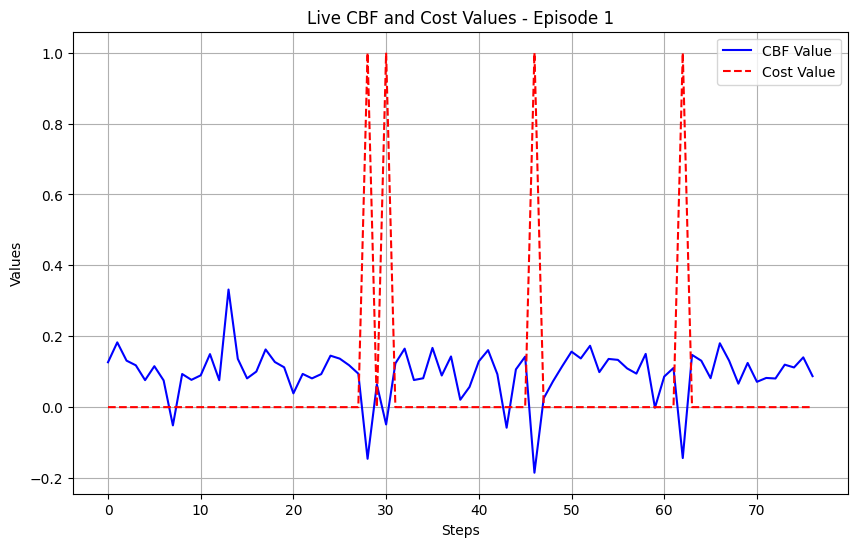

KeyboardInterrupt: 

In [36]:

##gd idk why
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from IPython.display import display, clear_output
import time
from torch.utils.data import DataLoader
from osrl.common.exp_util import seed_all

# Assuming these imports are correct and the modules are available
from network_ihab import CombinedCBFDynamics
from dataset_ihab import TransitionDataset

# Load model and hyperparameters
model_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_709/combined_model.pth"
hyperparams_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_709/hyperparameters.json"

seed_all(112)

# Load hyperparameters
with open(hyperparams_path, 'r') as f:
    hyperparams = json.load(f)

# Initialize and load the model
combinedcbfdynamics = CombinedCBFDynamics(
    num_action=hyperparams['num_action'],
    state_dim=hyperparams['state_dim'],
    cbf_hidden_dim=hyperparams['cbf_hidden_dim'],
    dynamics_hidden_dim=hyperparams['dynamics_hidden_dim'],
    cbf_num_layers=hyperparams['cbf_num_layers'],
    dynamics_num_layers=hyperparams['dynamics_num_layers'],
    dt=hyperparams['dt']
)

checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
combinedcbfdynamics.load_state_dict(checkpoint)
combinedcbfdynamics.eval()
print("Model loaded successfully!")

# Initialize environment
env = gym.make('OfflineSwimmerVelocityGymnasium-v1')
dataset = env.get_dataset()

# Process dataset (assuming these functions are defined elsewhere)
# env.set_target_cost(args.cost_limit)
# process_bc_dataset(dataset, args.cost_limit, args.gamma, args.bc_mode)

# Create a dataset and dataloader
dataset = TransitionDataset(dataset,split='val')
dataloader = DataLoader(dataset, batch_size=128)

# Get a batch of data
batch = next(iter(dataloader))
observations, next_observations, actions, _, costs, done = [b.to(torch.float32) for b in batch]

# Use the model to predict next states
with torch.no_grad():
    predicted_next_observations = combinedcbfdynamics.forward_next_state(observations, actions)
    cbf_values_batch = combinedcbfdynamics.forward_cbf(observations)

print("Sample observations:", observations[:5])
print("Sample CBF values:", cbf_values_batch[:5])
print("Sample costs:", costs[:5])

# Initialize data storage for plotting
cbf_values = []
cost_values = []
steps = []
episode_count = 0
max_episodes = 2

observation, info = env.reset()

while episode_count < max_episodes:
    for step_index in range(len(observations)):
        observation = observations[step_index].numpy()
        action = actions[step_index].numpy()

        # Compute CBF value
        obs_tensor = torch.FloatTensor(observation).unsqueeze(0)
        with torch.no_grad():
            cbf_value = combinedcbfdynamics.forward_cbf(obs_tensor).item()

        # Step in the environment
        obs_next, reward, terminated, truncated, info = env.step(action)

        # Store history
        cbf_values.append(cbf_value)
        cost = costs[step_index].item()  # Use the cost from the dataset
        cost_values.append(cost)
        steps.append(step_index)

        # Update the plot dynamically
        clear_output(wait=True)
        plt.figure(figsize=(10, 6))
        plt.plot(steps, cbf_values, 'b-', label="CBF Value")
        plt.plot(steps, cost_values, 'r--', label="Cost Value")
        plt.xlabel('Steps')
        plt.ylabel('Values')
        plt.title(f'Live CBF and Cost Values - Episode {episode_count + 1}')
        plt.legend()
        plt.grid(True)
        display(plt.gcf())
        plt.close()

        time.sleep(0.1)

        if terminated or truncated:
            break

    episode_count += 1
    print(f"Episode {episode_count} finished!")
    observation, info = env.reset()

print(f"Simulation finished after {episode_count} episodes.")
env.close()


In [37]:
from dataclasses import asdict, dataclass
from typing import Any, DefaultDict, Dict, List, Optional, Tuple
import os
import sys
import uuid
import types
from dataclasses import asdict
from typing import Any
import json
import random

sys.path.append("/Users/i.k.tabbara/Documents/python directory/OSRL")

import bullet_safety_gym  # noqa
import dsrl
import safety_gymnasium as gym
import numpy as np
import pyrallis
import torch
import wandb
from dsrl.infos import DENSITY_CFG
from dsrl.offline_env import OfflineEnvWrapper, wrap_env  # noqa
from torch.utils.data import DataLoader
from tqdm.auto import trange
from examples.configs.bc_configs import BC_DEFAULT_CONFIG, BCTrainConfig
import safety_gymnasium
from network_ihab import AffineDynamics, CBF, CombinedCBFDynamics
from dataset_ihab import TransitionDataset
import torch.nn.functional as F
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from IPython.display import display, clear_output  # For Jupyter updates
import time
from osrl.common.exp_util import auto_name, seed_all
from osrl.algorithms import BC, BCTrainer
from osrl.common.dataset import process_bc_dataset
from osrl.common.exp_util import auto_name, seed_all

from network_ihab import AffineDynamics, CBF, CombinedCBFDynamics
from dataset_ihab import TransitionDataset
import torch.nn.functional as F
import torch
import json
import matplotlib.pyplot as plt
seed_all(0)
import dsrl
import numpy as np
import pyrallis
import torch
from pyrallis import field
from dsrl.offline_env import OfflineEnvWrapper, wrap_env
from bc_modif import BC, BCTrainer
from osrl.common.exp_util import load_config_and_model, seed_all
import safety_gymnasium
model_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_709/combined_model.pth"
hyperparams_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_709/hyperparameters.json"
seed_all(112)
with open(hyperparams_path, 'r') as f:
    hyperparams = json.load(f)

combinedcbfdynamics = CombinedCBFDynamics(
    num_action=hyperparams['num_action'],
    state_dim=hyperparams['state_dim'],
    cbf_hidden_dim=hyperparams['cbf_hidden_dim'],
    dynamics_hidden_dim=hyperparams['dynamics_hidden_dim'],
    cbf_num_layers=hyperparams['cbf_num_layers'],
    dynamics_num_layers=hyperparams['dynamics_num_layers'],
    dt=hyperparams['dt']
)

# Load checkpoint
checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
combinedcbfdynamics.load_state_dict(checkpoint)
combinedcbfdynamics.eval()
print("Model loaded successfully!")
@dataclass
class EvalConfig:
    path: str = "/Users/i.k.tabbara/Documents/python directory/OSRL/logs/OfflineSwimmerVelocityGymnasium-v1-cost-20/BC-all_cost20_seed20-4653/BC-all_cost20_seed20-4653"
    noise_scale: List[float] = None
    costs: List[float] = field(default=[1, 10, 20, 30, 40], is_mutable=True)
    eval_episodes: int = 20
    best: bool = False
    device: str = "cpu"
    threads: int = 4
args=EvalConfig

cfg, model = load_config_and_model(args.path, args.best)
args.seed = 7  # Changed seed
seed_all(args.seed)
if args.device == "cpu":
    torch.set_num_threads(args.threads)

import gymnasium as gym  # noqa
# env = safety_gymnasium.make("SafetySwimmerVelocity-v1", render_mode="human")#SafetyCarGoal1-v0  SafetyAntVelocity-v1 SafetySwimmerVelocity-v1


env = gym.make("OfflineSwimmerVelocityGymnasium-v1")#OfflineCarGoal1-v0  OfflineAntVelocityGymnasium-v1 OfflineSwimmerVelocityGymnasium-v1
dataset = env.get_dataset()
# env = safety_gymnasium.make("SafetySwimmerVelocity-v1", render_mode="human")#SafetyCarGoal1-v0  SafetyAntVelocity-v1 SafetySwimmerVelocity-v1

env = gym.make("SafetySwimmerVelocityGymnasium-v1")
# model & optimizer & scheduler setup
state_dim = env.observation_space.shape[0]
if cfg["bc_mode"] == "multi-task":
    state_dim += 1
bc_model = BC(
    state_dim=state_dim,
    action_dim=env.action_space.shape[0],
    max_action=env.action_space.high[0],
    a_hidden_sizes=cfg["a_hidden_sizes"],
    episode_len=cfg["episode_len"],
    device=args.device,
)
bc_model.load_state_dict(model["model_state"])
bc_model.to(args.device)

trainer = BCTrainer(bc_model,
                    env,
                    bc_mode=cfg["bc_mode"],
                    cost_limit=cfg["cost_limit"],
                    device=args.device)

# action=trainer.model.act(env.observation_space.sample())
# print(action)
# Initialize data storage
cbf_values = []
cost_values = []  # New array to store cost values
steps = []
episode_count = 0
step_index = 0  # Track dataset index

# Start the first episode
observation, info = env.reset()

while episode_count < 2 and step_index < len(dataset['observations']):
    # Get observation and action
    observation = dataset['observations'][step_index]
    action = dataset['actions'][step_index]
    # action=trainer.model.act(observation)

    # Compute CBF value
    obs_tensor = torch.FloatTensor(observation).unsqueeze(0)
    
    with torch.no_grad():
        cbf_value = combinedcbfdynamics.forward_cbf(obs_tensor).item()
        print(cbf_value)
        print(cost)

    # Step in the environment
    next_obs, reward, terminated, truncated, info = env.step(action)
    # next_obs, reward, cost, terminated, truncated, info = env.step(env.action_space.sample())
   

    # Render environment
    env.render()

    # Print step details
    
    # print(f"observation {next_obs[56:72]}")#hazards40:56   vases56:72  ##UNCOMMENT TO PRINT OBSERVATIONS

    # Store history
    cbf_values.append(cbf_value)
    cost_values.append(info['cost'])  # Store cost values
    steps.append(step_index)

    # **Update the plot dynamically in Jupyter**
    
    clear_output(wait=True)  ##UNCOMMENT TO PLOT CBF
    
    plt.figure(figsize=(6, 4))

    plt.plot(steps, cbf_values, 'b-', label="CBF Value")  # CBF plot
    plt.plot(steps, cost_values, 'r--', label="Cost Value")  # Cost plot (red dashed line)
    
    plt.xlabel('Steps')
    plt.ylabel('Values')
    plt.title('Live CBF and Cost Values')
    plt.legend()
    plt.grid(True)

    plt.show() ##UNCOMMENT TO PLOT CBF
    
    # time.sleep(0.1)

    # Check for episode termination
    if terminated or truncated:
        episode_count += 1
        print(f"Episode {episode_count} finished!")
        observation, info = env.reset()

    step_index += 1

# Close the environment
print(f"Simulation finished after {episode_count} episodes.")
env.close()

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Model loaded successfully!
load config from /Users/i.k.tabbara/Documents/python directory/OSRL/logs/OfflineSwimmerVelocityGymnasium-v1-cost-20/BC-all_cost20_seed20-4653/BC-all_cost20_seed20-4653/config.yaml
load model from /Users/i.k.tabbara/Documents/python directory/OSRL/logs/OfflineSwimmerVelocityGymnasium-v1-cost-20/BC-all_cost20_seed20-4653/BC-all_cost20_seed20-4653/checkpoint/model.pt
Loading dataset from /Users/i.k.tabbara/.dsrl/datasets/SafetySwimmerVelocityGymnasium-v1-200-1686.hdf5


load datafile: 100%|██████████| 7/7 [00:00<00:00, 10.25it/s]

0.10350456833839417
0.0


AttributeError: Unexpected mode: None, expected modes: human, rgb_array, or depth_array

In [9]:
import random
random.seed(42)
print(random.random())  # Always the same output
print(random.random())  # Always the same output
print(random.random())  # Always the same output
print(random.random())  # Always the same output
print(random.random())  # Always the same output
print(random.random())  # Always the same output
print(random.randint(1, 10))  # Always the same output
print(random.randint(1, 10))  # Always the same output
print(random.randint(1, 10))  # Always the same output



0.6394267984578837
0.025010755222666936
0.27502931836911926
0.22321073814882275
0.7364712141640124
0.6766994874229113
9
2
10
